In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
fig_width_pt = 420.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = 1.6*fig_width*golden_mean      # height in inches
fig_size =  [fig_width*1.2,fig_height]
params = {'backend': 'pdf',
         'axes.labelsize': 14,
         'font.size': 14,
         'legend.fontsize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'text.usetex': True,
         'figure.figsize': fig_size}
mpl.rcParams.update(params)

In [4]:
import rompy as rp

In [5]:
import pycbc
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import amplitude_from_frequencyseries, phase_from_frequencyseries
from pycbc import pnutils

In [6]:
pnutils.mtotal_eta_to_mass1_mass2(100, 0.25)

(50.0, 50.0)

In [7]:
import phenom

In [8]:
phenom.m1_m2_M_q(100, 1)

(50.0, 50.0)

In [9]:
def mask_array(x, y, x1, x2):
    mask = (x>=x1) & (x<=x2)
    newx = x[mask]
    newy = y[mask]
    return newx, newy

In [10]:
def make_training_set(qlist=np.linspace(1, 5, 20),
                      f_lower=30,
                      delta_f=0.01,
                      spin1z=0.,
                      approximant="IMRPhenomD",
                      fstart=30.,
                      fend=300.,
                      align_phase=True):
    npts=len(qlist)
    mtot=100
    amp=[None]*npts
    phase=[None]*npts
    for i,q in enumerate(qlist):
        print(i)
        m1,m2 = phenom.m1_m2_M_q(mtot, q)
        hp, _ = get_fd_waveform(mass1=m1,
                                mass2=m2,
                                spin1z=spin1z,
                                delta_f=delta_f,
                                f_lower=f_lower,
                                approximant=approximant)
        amp_ts = amplitude_from_frequencyseries(hp)
        phase_ts = phase_from_frequencyseries(hp)
        
        
        
        
        if i==0:
            flist, amp[i] = mask_array(amp_ts.sample_frequencies, amp_ts.data, fstart, fend)
        else:
            _, amp[i] = mask_array(amp_ts.sample_frequencies, amp_ts.data, fstart, fend)
            
        _, phi_tmp = mask_array(phase_ts.sample_frequencies, phase_ts.data, fstart, fend)
        if align_phase == True:
            #aligned phase
            #subtract off a linear function over the freq interval [fstart, fend]
#             z = np.polyfit(flist[flist<100], phi_tmp[flist<100], 1)
            z = np.polyfit(flist, phi_tmp, 1)
            p = np.poly1d(z)
            phi_tmp -= p(flist)

#         _, phase[i] = mask_array(phase_ts.sample_frequencies, phase_ts.data, fstart, fend)
        phase[i] = phi_tmp
#         phase[i] = phi_tmp * phenom.eta_from_q(q)
#         phase[i] = phi_tmp / q
        
    return np.array(flist), np.array(amp), np.array(phase)
        

In [11]:
qlist=np.linspace(1,20,20)

In [63]:
# f,am,ph=make_training_set(qlist=qlist, align_phase=True, approximant="SEOBNRv4_ROM")
f,am,ph=make_training_set(qlist=qlist, align_phase=True, approximant="IMRPhenomD")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [64]:
f

array([ 30.  ,  30.01,  30.02, ..., 299.98, 299.99, 300.  ])

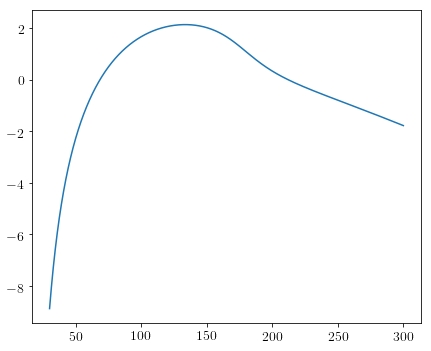

In [65]:
plt.figure()
plt.plot(f, ph[0])

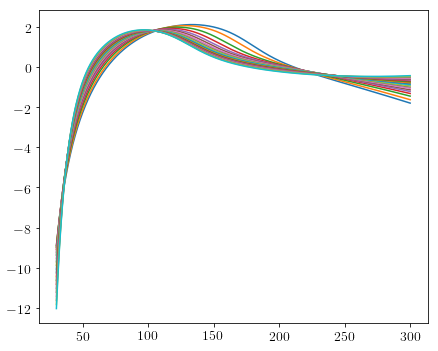

In [66]:
plt.figure()
for i in range(len(ph)):
    plt.plot(f, ph[i])
    

In [67]:
def compute_svd(matrix):
    u, s, vh          = np.linalg.svd(matrix, full_matrices=False)
    return u,s,vh

In [68]:
ph.shape

(20, 27001)

In [69]:
u,s,vh = compute_svd(ph)
# u,s,vh = compute_svd(am)

In [70]:
print("u.shape = {0}".format(u.shape))
print("s.shape = {0}".format(s.shape))
print("vh.shape = {0}".format(vh.shape))

u.shape = (20, 20)
s.shape = (20,)
vh.shape = (20, 27001)


In [71]:
s

array([1.23509383e+03, 1.95037369e+02, 2.58123633e+01, 8.77164237e+00,
       1.57756888e+00, 4.31652340e-01, 7.42349928e-02, 1.30498007e-02,
       2.07752405e-03, 8.06115616e-04, 4.46252178e-04, 2.51758922e-04,
       1.60174397e-04, 1.01909312e-04, 6.65118274e-05, 4.81653832e-05,
       3.24015510e-05, 2.30796578e-05, 1.65324085e-05, 7.65549944e-06])

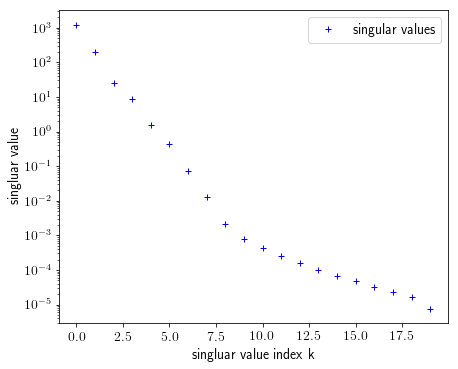

In [72]:
# From the above discussion, faster decaying singular values means the matrix/model is easier
# to compress
plt.semilogy(range(len(ph)),s,'b+', label='singular values')
plt.ylabel('singluar value')
plt.xlabel('singluar value index k')
plt.legend(loc='best')

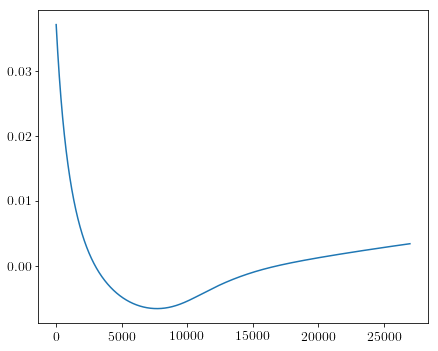

In [73]:
plt.plot(vh[0])

In [74]:
# Decide on how many column vectors to use as the basis
# basis_size = 3
# basis_size = 5
basis_size = 6
# basis_size = 7
# More vectors -> more accuracy but also more computational cost 
# basis_size = -1
basis_set  = vh[0:basis_size,:]

In [75]:
def compute_projection_coeffs(RB, ref_data):
    proj_coeffs = np.array([ np.dot(RB, ref_data[i]) for i in range(len(ref_data)) ] )
    return proj_coeffs

In [76]:
proj_coeffs = compute_projection_coeffs(basis_set, ph)

In [77]:
proj_coeffs.shape

(20, 6)

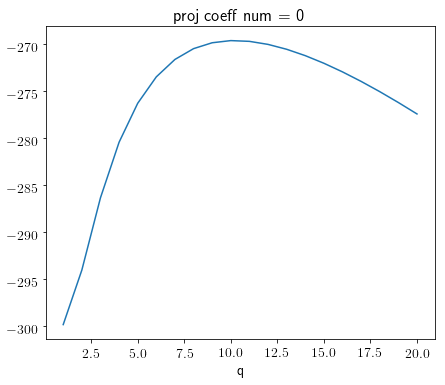

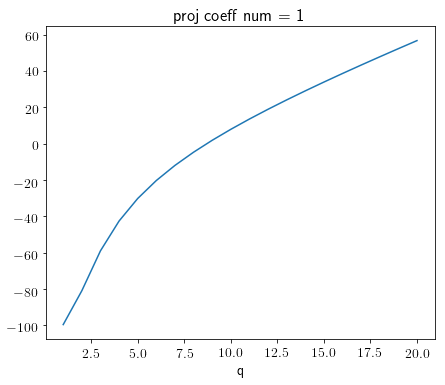

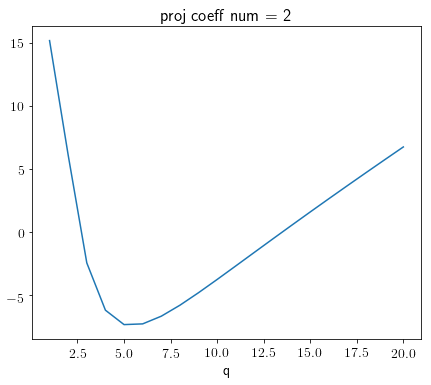

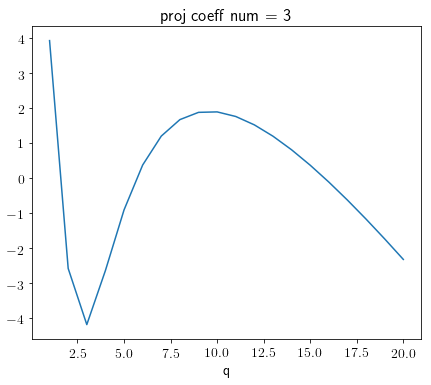

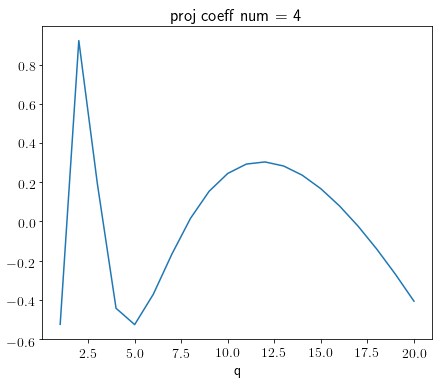

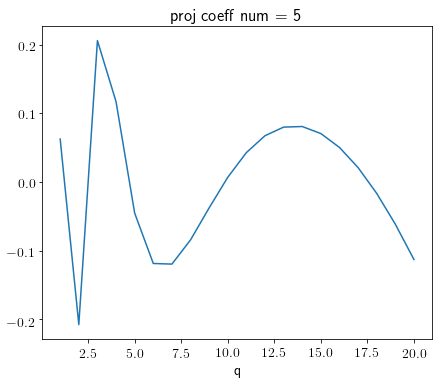

In [78]:
for i in range(basis_size):
    plt.figure()
    plt.plot(qlist, proj_coeffs[:,i])
    plt.xlabel('q')
    plt.title('proj coeff num = {0}'.format(i))

In [79]:
def test_reduced_basis(flist, ref_data, idx, qlist, RB):
    ref_data=ref_data[idx]
    # compute projection coefficient
    proj_coeffs = np.dot(RB, ref_data)
    # compute representation in linear space defined by the span of the basis set
    approx_data = np.dot(proj_coeffs, RB)
#     approx_data = approx_data.transpose()
    
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    fig.suptitle('idx = {0}, q = {1:.3f}'.format(idx, qlist[idx]), fontsize=12)

    axes[0].plot(flist, ref_data, label='ref data')
    axes[0].plot(flist, approx_data, label='approx data')
    axes[0].legend()
    
    err = np.abs(ref_data - approx_data)
    axes[1].plot(flist, err, label='err')
    axes[1].set_yscale('log')
    axes[1].legend()
    
    plt.show()

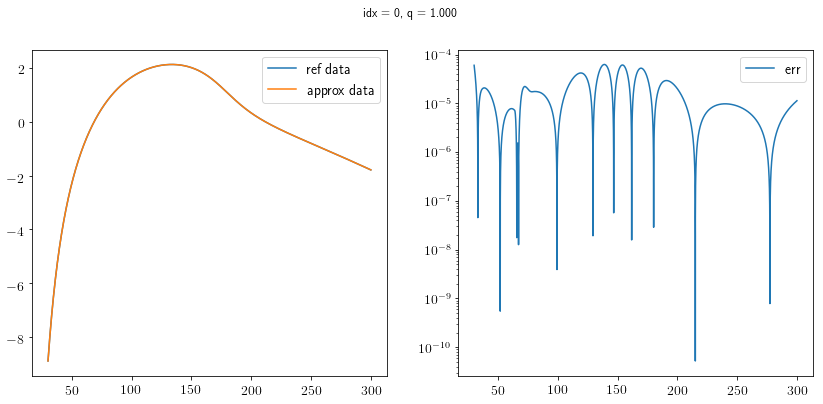

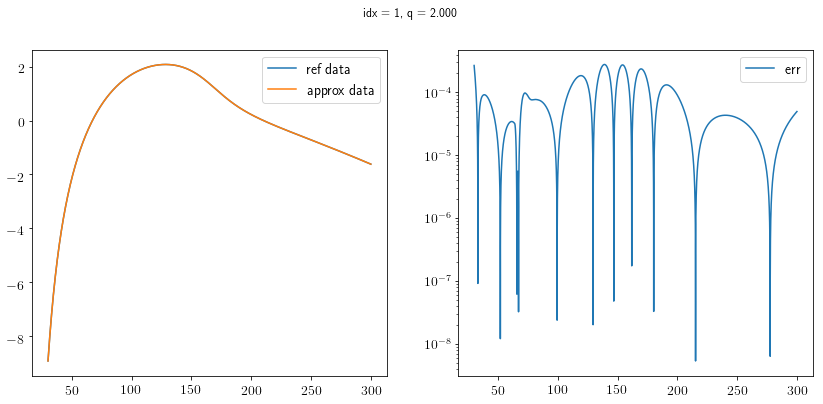

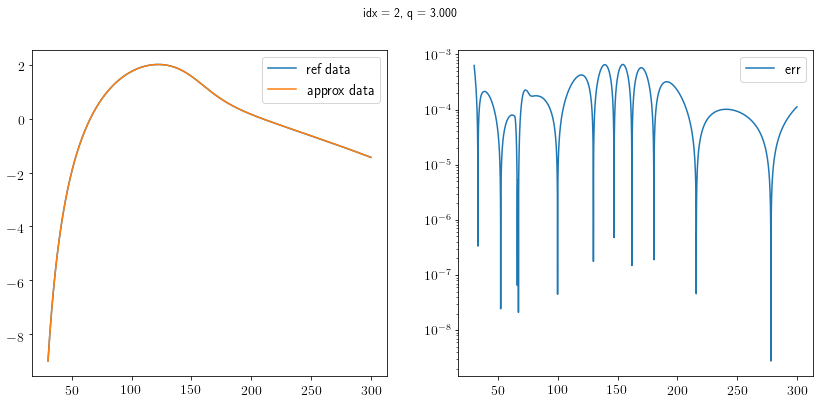

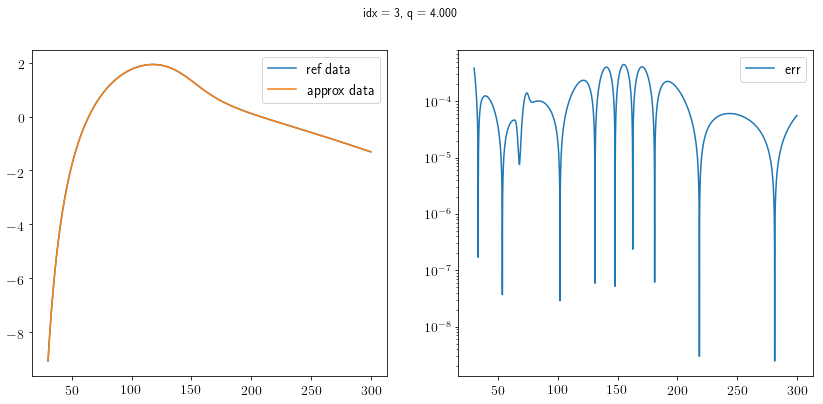

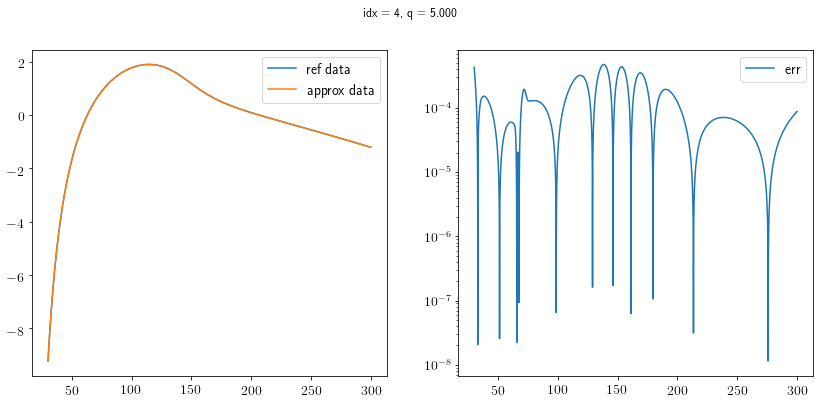

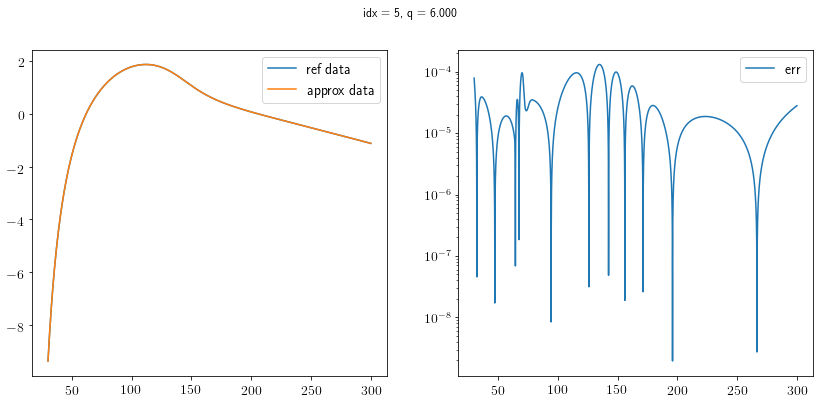

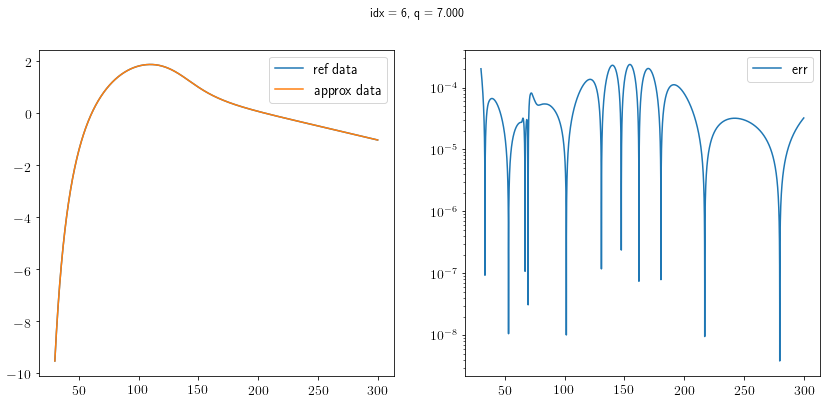

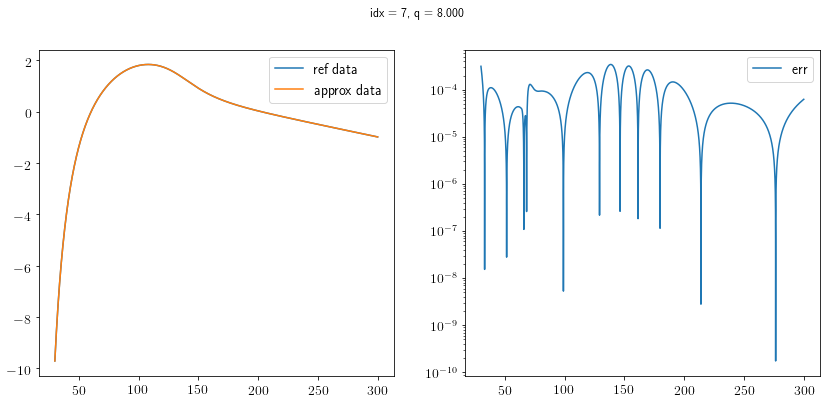

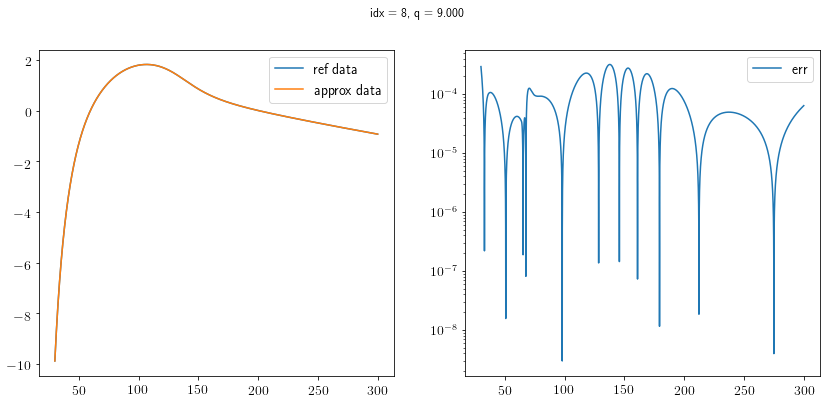

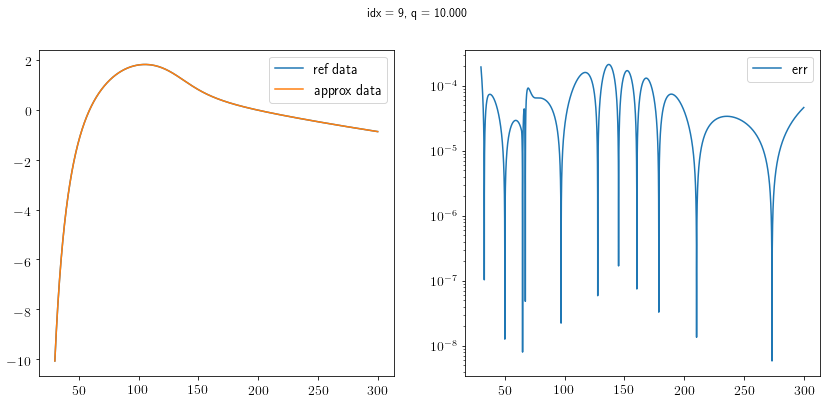

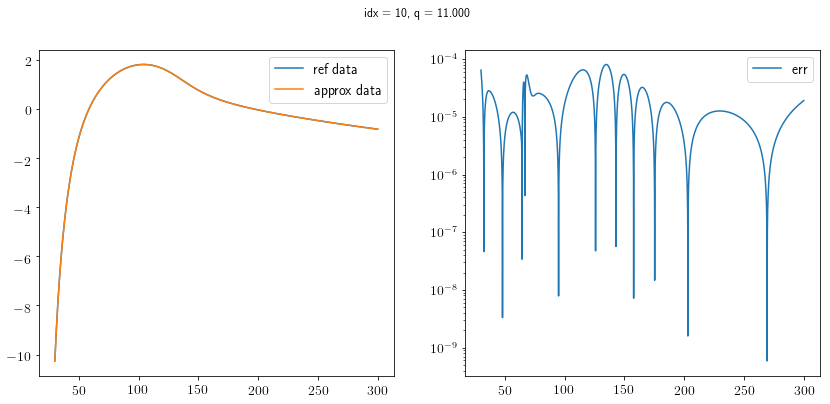

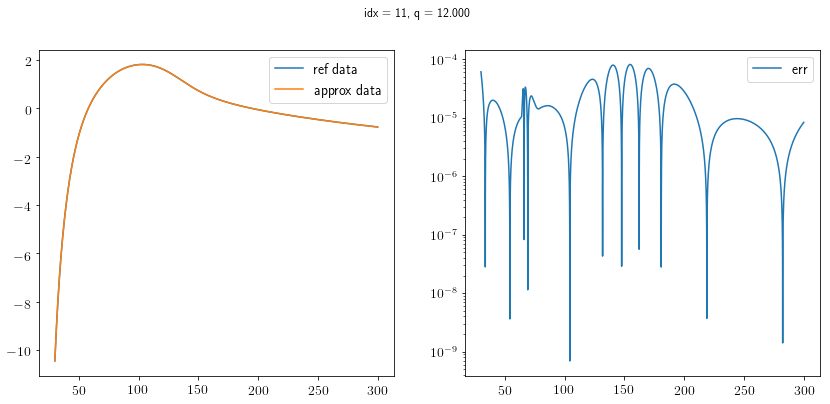

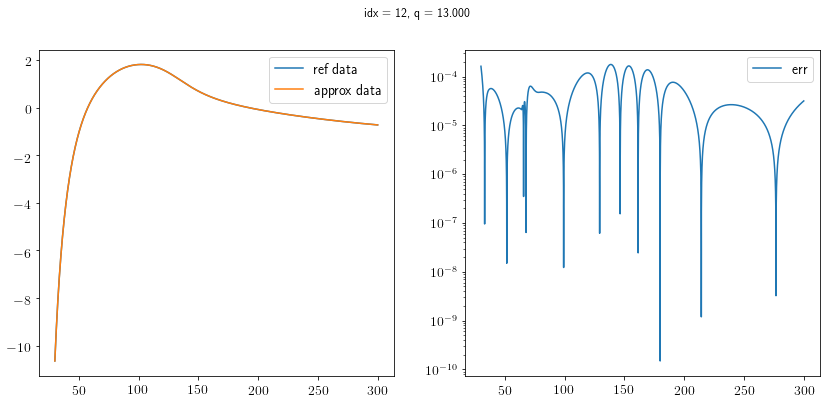

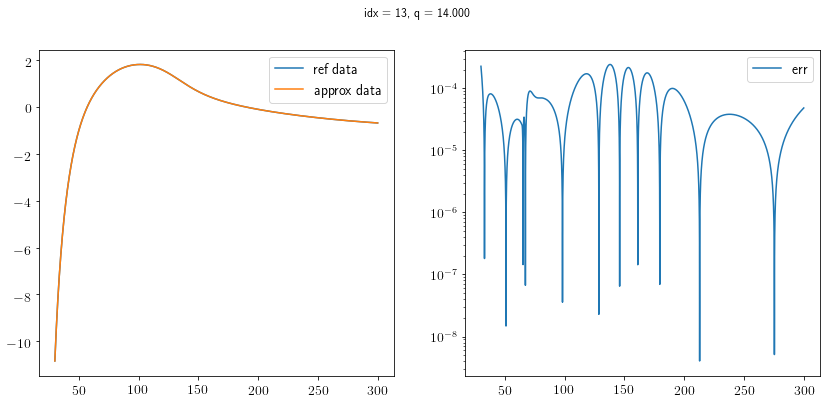

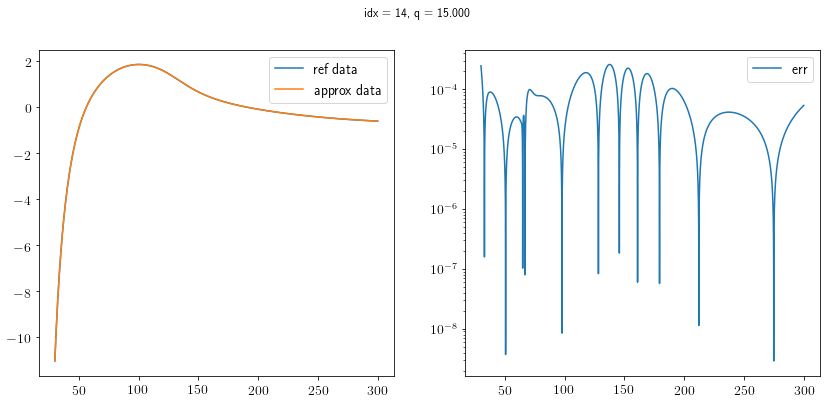

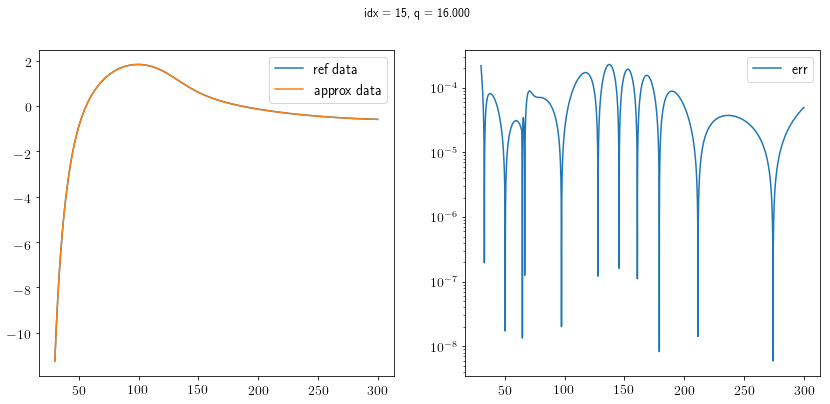

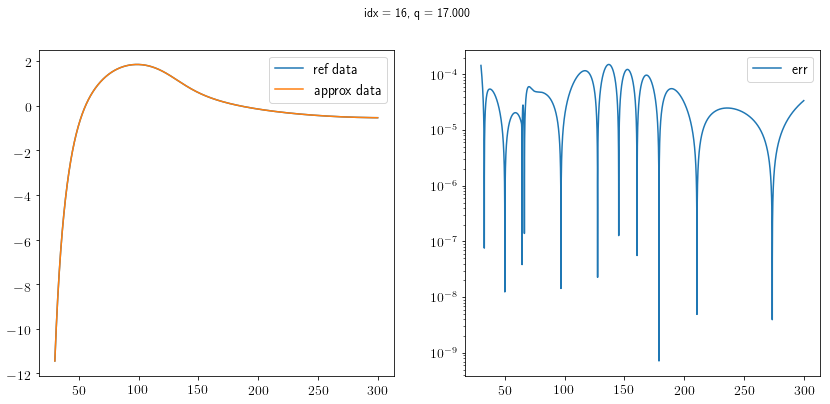

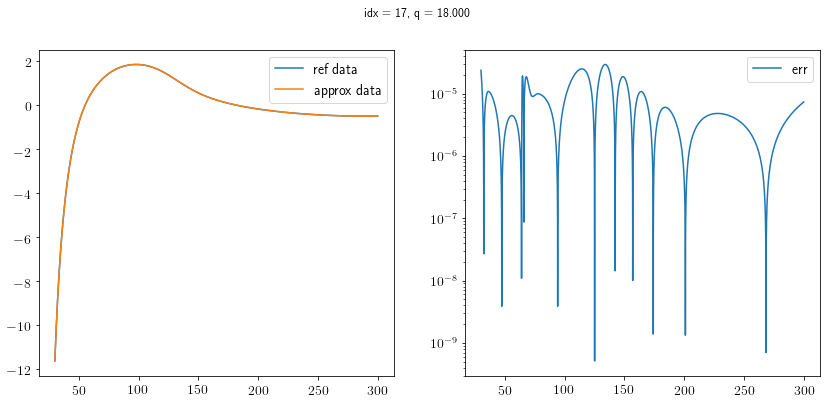

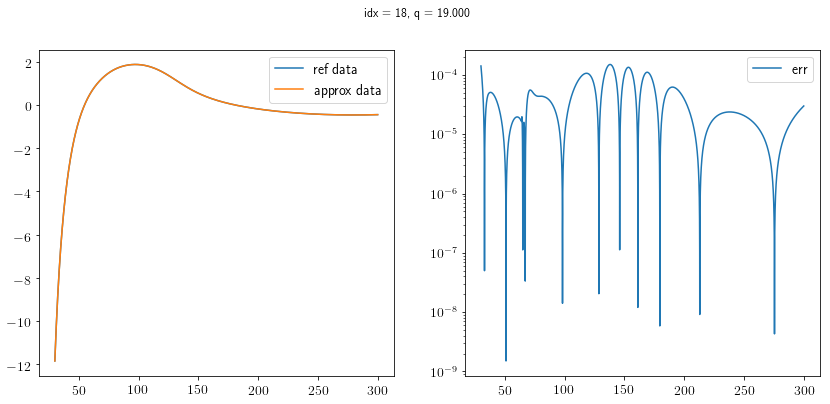

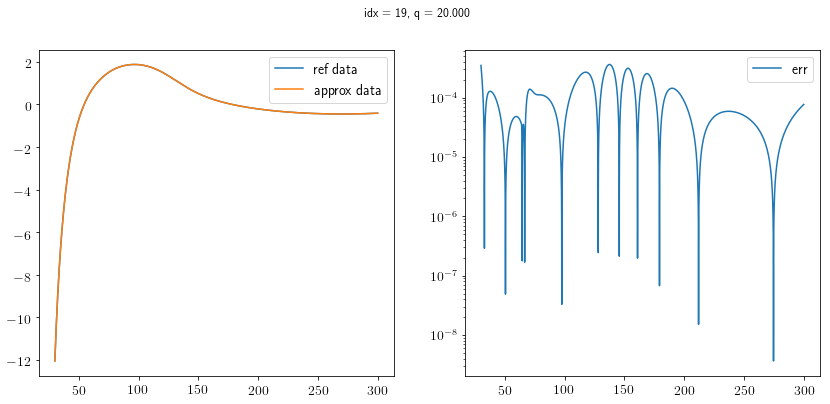

In [93]:
for i in range(len(ph)):
    test_reduced_basis(f, ph, i, qlist, basis_set)

In [81]:
eim = rp.EmpiricalInterpolant(basis_set, verbose=True) # Note the transpose


Step 	Nodes
1 	0
2 	1261
3 	13188
4 	11163
5 	15058
6 	9744


In [82]:
# the most important pieces of information are the interpolation times T_i and the basis B_i
eim_indicies = eim.indices
B = eim.B

In [83]:
eim_indicies.shape

(6,)

In [84]:
B.shape

(6, 27001)

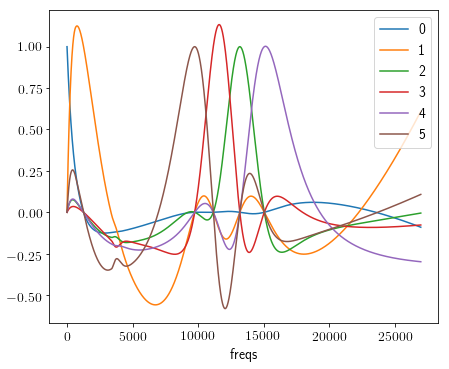

In [85]:
for i in range(len(B)):
    plt.plot(B[i], label=i)
plt.xlabel('freqs')
plt.legend()

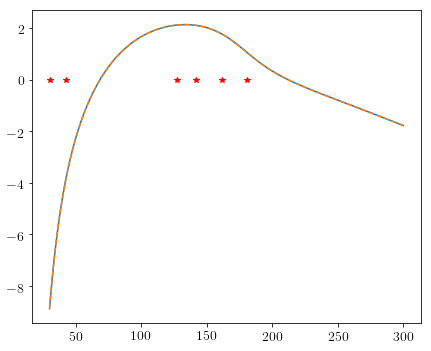

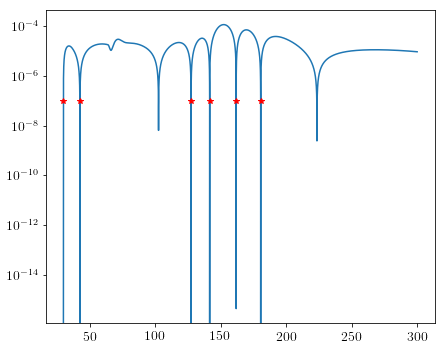

In [86]:

# compute the phase using the empirical interpolation nodes

f_eim = f[eim_indicies]

ph_eim = ph[0][eim_indicies]
approx_ph = np.dot(B.transpose(), ph_eim)

plt.figure(1)
plt.plot(f,ph[0])
plt.plot(f,approx_ph, ls='--')
plt.plot(f_eim,np.zeros_like(f_eim),'r*')


plt.figure(2)
plt.plot(f,np.abs(ph[0]-approx_ph))
plt.plot(f_eim,np.ones_like(f_eim)*1e-7,'r*')
plt.yscale('log')


## looking at empirical nodes over parameter space

In [87]:
eim_values = np.array([ ph[i][eim_indicies] for i in range(len(qlist)) ])

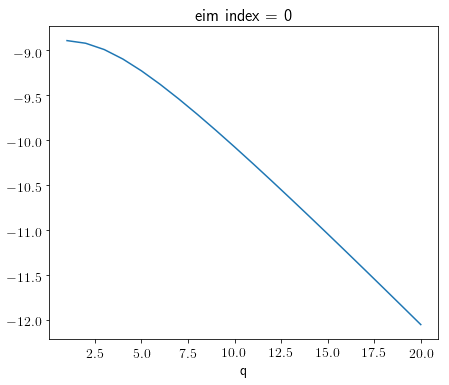

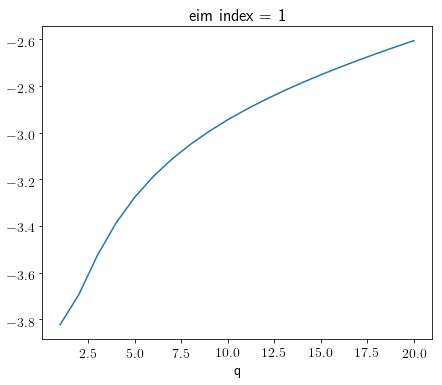

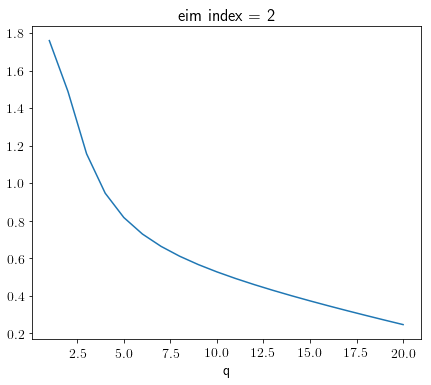

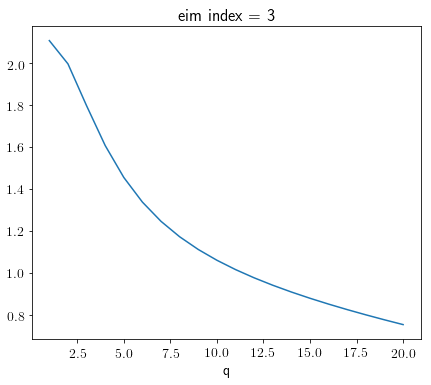

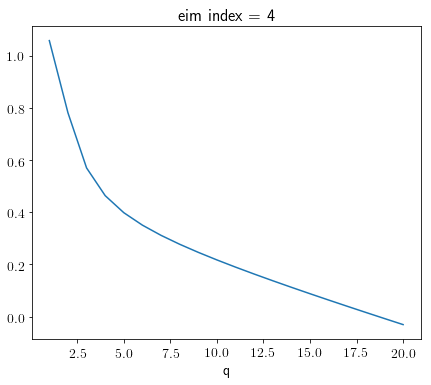

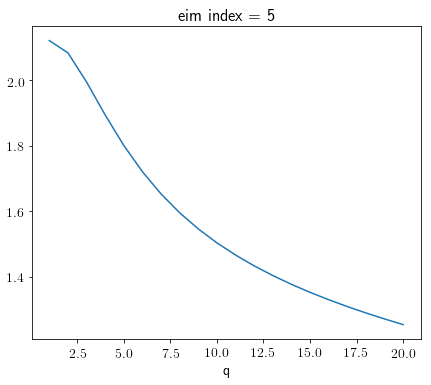

In [88]:
for i in range(len(eim_indicies)):
    plt.figure()
    plt.plot(qlist, eim_values[:,i])
    plt.xlabel('q')
    plt.title('eim index = {0}'.format(i))
#     plt.yscale('log')
#     plt.xscale('log')

In [89]:
eim_values.shape

(20, 6)

In [90]:
eim_u, eim_s, eim_vh = np.linalg.svd(eim_values, full_matrices=False)

In [91]:
eim_s.shape

(6,)

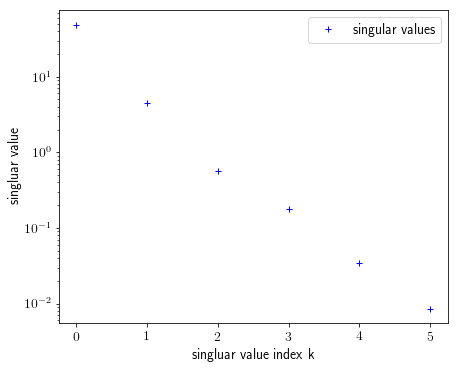

In [92]:
# From the above discussion, faster decaying singular values means the matrix/model is easier
# to compress
plt.semilogy(range(len(eim_vh)), eim_s,'b+', label='singular values')
plt.ylabel('singluar value')
plt.xlabel('singluar value index k')
plt.legend(loc='best')